In [0]:
'''
[1] https://rsandstroem.github.io/sparkkmeans.html
'''

'\n[1] https://rsandstroem.github.io/sparkkmeans.html\n'

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
!git clone https://github.com/dipanjanS/practical-machine-learning-with-python.git

Cloning into 'practical-machine-learning-with-python'...
remote: Enumerating objects: 1446, done.
remote: Total 1446 (delta 0), reused 0 (delta 0), pack-reused 1446
Receiving objects: 100% (1446/1446), 118.41 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (427/427), done.
Checking out files: 100% (491/491), done.


In [0]:
cd practical-machine-learning-with-python/notebooks/Ch08_Customer_Segmentation_and_Effective_Cross_Selling/

/content/practical-machine-learning-with-python/notebooks/Ch08_Customer_Segmentation_and_Effective_Cross_Selling/practical-machine-learning-with-python/notebooks/Ch08_Customer_Segmentation_and_Effective_Cross_Selling


In [0]:
from __future__ import print_function

import time
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab 
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import SparkSession as ss
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import *

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans as KMeans_lib


In [0]:
# convert xlsx to csv for Spark
pd_df = pd.read_excel('Online Retail.xlsx')
pd_df.to_csv('Online Retail.csv')
pd_csv = pd.read_csv('Online Retail.csv')

In [0]:
# create RDD
spark = ss.builder.appName('Create RDD Spark').getOrCreate()

In [0]:
sp_df_main = sp_df = spark.read.csv(path = 'practical-machine-learning-with-python/notebooks/Ch08_Customer_Segmentation_and_Effective_Cross_Selling/Online Retail.csv', 
                       encoding = 'UTF-8', sep = ',', header = True, inferSchema = True)

note: we need to find a path for spark because spark not based on cd command !!! ( if we did not provide path, spark will find a file at '' /content/.....file name..... '' )

##<font color = lightpink >Data understanding and Data exploration</font>  

In [0]:
sp_df.show(5)

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------

In [0]:
sp_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [0]:
sp_df.describe().show()

+-------+------------------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|summary|               _c0|        InvoiceNo|         StockCode|         Description|          Quantity|         UnitPrice|        CustomerID|    Country|
+-------+------------------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|  count|            541909|           541909|            541909|              540455|            541909|            541909|            406829|     541909|
|   mean|          270954.0| 559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|4.6111136260829975|15287.690570239585|       null|
| stddev|156435.79785064116|13428.41728080189|16799.737628427796|                 NaN|218.08115785023475| 96.75985306117992|1713.6003033215986|       null|
|    min|                 0|           536365|             10002

In [0]:
num_order = sp_df.select('Country').groupby('Country').count()
num_order.orderBy(['count'], ascending = False).show()

+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|495478|
|        Germany|  9495|
|         France|  8557|
|           EIRE|  8196|
|          Spain|  2533|
|    Netherlands|  2371|
|        Belgium|  2069|
|    Switzerland|  2002|
|       Portugal|  1519|
|      Australia|  1259|
|         Norway|  1086|
|          Italy|   803|
|Channel Islands|   758|
|        Finland|   695|
|         Cyprus|   622|
|         Sweden|   462|
|    Unspecified|   446|
|        Austria|   401|
|        Denmark|   389|
|          Japan|   358|
+---------------+------+
only showing top 20 rows



##<font color = lightpink >Data Preparation [Cleaning + Feature engineering]

##<font color = lightpink > Data Cleaning

In [0]:
sp_df = sp_df.withColumn('amount', (F.col('Quantity') * F.col('UnitPrice'))); sp_df.show(5)

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|            amount|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.3

In [0]:
sp_df = sp_df.filter(sp_df['amount']>0); sp_df.describe().show()
# customerID have been reduced so we can guarantee that we already remove the refund amount (-)

+-------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+------------------+
|summary|               _c0|         InvoiceNo|         StockCode|         Description|          Quantity|         UnitPrice|        CustomerID|    Country|            amount|
+-------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+------------------+
|  count|            530104|            530104|            530104|              530104|            530104|            530104|            397884|     530104|            530104|
|   mean|271365.70560305147| 559981.4746888812|27591.351654656588|                null|10.542037034242338|3.9076252471180233|15294.423452564064|       null| 20.12187145164017|
| stddev| 156559.0135870024|13430.049737659414|16756.848658106683|                null|155.52412351063572|35.91568110425

In [0]:
sp_df_uk = sp_df.filter(sp_df['Country'] == 'United Kingdom'); sp_df_uk.show(5)


+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|            amount|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.3

In [0]:
sp_df_uk = sp_df_uk.dropna(how = 'any'); sp_df_uk.describe().show()

+-------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------+------------------+
|summary|               _c0|         InvoiceNo|         StockCode|         Description|          Quantity|         UnitPrice|        CustomerID|       Country|            amount|
+-------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------+------------------+
|  count|            354321|            354321|            354321|              354321|            354321|            354321|            354321|        354321|            354321|
|   mean|279186.83620220085| 560672.5213295289|27651.354158318012|                null|12.013795400216187|2.9639935651588547|15552.486392282704|          null|  20.6264702176846|
| stddev|153564.48033048748|13168.903430348591| 16726.71088666236|                null|189.26795625360555

##<font color = lightpink > Feature Engineering </font>
*   [R] Recency – How recently did the customer purchase?
*   [F] Frequency – How often do they purchase?
*   [M] Monetary Value – How much do they spend?
    
โดยเราอาจจะส่งแคมเปญที่ต่างกันไปแบบนี้
1.   Recency ↑ , Frequency 	↑ , Monetary	↑ : ให้ความสำคัญกับลูกค้าที่สุดพิเศษ เช่น เสนอสิทธิ์ส่งฟรี เป็นต้น
2.   Recency 	↑, Frequency 	↓ , Monetary 	↓ : ในส่วนนี้จะรวมไปถึงลูกค้าใหม่ด้วย เราต้องสร้างความประทับใจแรก เช่น โปรโมชันต้อนรับ หรือทริคในการใช้สินค้าของเรา หรือข้อมูลอื่นๆที่เป็นประโยชน์แก่ลูกค้าใหม่ เป็นต้น
3. Recency 	↓ , Frequency 	↓ , Monetary 	↓ : อาจจะส่ง re-opt-in แคมเปญไปให้ และเช็กว่าลูกค้ายังสนใจเราอยู่หรือไม่

In [0]:
'''################################## R : Recency ##########################################'''

sp_InD  = sp_df_uk.select(['InvoiceDate', 'CustomerID'])
sp_InD.show(5)

+-------------------+----------+
|        InvoiceDate|CustomerID|
+-------------------+----------+
|2010-12-01 08:26:00|   17850.0|
|2010-12-01 08:26:00|   17850.0|
|2010-12-01 08:26:00|   17850.0|
|2010-12-01 08:26:00|   17850.0|
|2010-12-01 08:26:00|   17850.0|
+-------------------+----------+
only showing top 5 rows



In [0]:
# Since Spark not support datetime (when use collect(), the values are not the same. (: => ,)), we will convert to Pandas
pd_InD = sp_InD.select("*").toPandas()

/content/spark-2.4.1-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [0]:
pd_InD.head()

,InvoiceDate,CustomerID
0,2010-12-01 08:26:00,17850.0
1,2010-12-01 08:26:00,17850.0
2,2010-12-01 08:26:00,17850.0
3,2010-12-01 08:26:00,17850.0
4,2010-12-01 08:26:00,17850.0


In [0]:
last_order = np.max(pd_InD.InvoiceDate)
ref_date = last_order + datetime.timedelta(days = 1) # Assume that we count a day after last purchase.
pd_InD['days_since_last_purchase'] = ref_date - pd_InD.InvoiceDate
pd_InD['days_since_last_purchase_num'] = pd_InD['days_since_last_purchase'].astype('timedelta64[D]') # remove some infor from days_since_last_purchase
pd_InD = pd_InD.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
pd_InD = pd_InD.rename(columns={'days_since_last_purchase_num':'recency'})

In [0]:
pd_InD.describe()

,CustomerID,recency
count,3920.000000,3920.000000
mean,15562.059694,92.208418
std,1576.594671,99.533854
min,12346.000000,1.000000
25%,14208.750000,18.000000
50%,15569.500000,51.000000
75%,16913.250000,143.000000
max,18287.000000,374.000000


In [0]:
#convert back
spark.conf.set('spark.sql.execution.arrow.enabled', 'true')
sp_InD = spark.createDataFrame(pd_InD)
sp_InD.show(5)

/content/spark-2.4.1-bin-hadoop2.7/python/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


+----------+-------+
|CustomerID|recency|
+----------+-------+
|   12346.0|  326.0|
|   12747.0|    2.0|
|   12748.0|    1.0|
|   12749.0|    4.0|
|   12820.0|    3.0|
+----------+-------+
only showing top 5 rows



In [0]:
sp_InD.describe().show()

+-------+-----------------+-----------------+
|summary|       CustomerID|          recency|
+-------+-----------------+-----------------+
|  count|             3920|             3920|
|   mean|15562.05969387755|92.20841836734694|
| stddev|1576.594671066021|99.53385449898356|
|    min|          12346.0|              1.0|
|    max|          18287.0|            374.0|
+-------+-----------------+-----------------+



In [0]:
sp_df_uk.show(5)

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|            amount|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.3

In [0]:
sp_customer_hist = sp_InD  

In [0]:
''' ##################################### F ###########################################'''

customer_freq = sp_df_uk.groupby('CustomerID').count()
customer_freq = customer_freq.withColumnRenamed('count','frequency'); customer_freq.show()

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|   16916.0|      143|
|   17884.0|      117|
|   13094.0|       24|
|   16596.0|       12|
|   18114.0|       28|
|   13973.0|       11|
|   14473.0|        7|
|   13956.0|      152|
|   13533.0|       76|
|   13918.0|       30|
|   14285.0|       27|
|   15776.0|       18|
|   14768.0|        5|
|   17267.0|       38|
|   14024.0|       16|
|   17633.0|       70|
|   16629.0|       64|
|   14452.0|       62|
|   16561.0|       31|
|   13607.0|       98|
+----------+---------+
only showing top 20 rows



In [0]:
customer_freq.describe().show()

+-------+------------------+-----------------+
|summary|        CustomerID|        frequency|
+-------+------------------+-----------------+
|  count|              3920|             3920|
|   mean| 15562.05969387755|90.38801020408164|
| stddev|1576.5946710660269|217.8083852518347|
|    min|           12346.0|                1|
|    max|           18287.0|             7847|
+-------+------------------+-----------------+



In [0]:
'''###################################### M (amount) ####################################'''

customer_amount = sp_df_uk.groupby('CustomerID').sum()
customer_amount = customer_amount.select('CustomerID','sum(amount)')
customer_amount = customer_amount.withColumnRenamed('sum(amount)','monetary');
customer_amount.show(5)

+----------+------------------+
|CustomerID|          monetary|
+----------+------------------+
|   16916.0| 576.2599999999999|
|   17884.0| 717.4499999999998|
|   13094.0|1927.3200000000002|
|   16596.0|            250.15|
|   18114.0|             220.1|
+----------+------------------+
only showing top 5 rows



In [0]:
customer_amount.describe().show()

+-------+------------------+------------------+
|summary|        CustomerID|          monetary|
+-------+------------------+------------------+
|  count|              3920|              3920|
|   mean| 15562.05969387755|1864.3856005102032|
| stddev|1576.5946710660269| 7482.817476870344|
|    min|           12346.0|              3.75|
|    max|           18287.0|259657.29999999996|
+-------+------------------+------------------+



In [0]:
sp_customer_hist = sp_customer_hist.join(customer_freq, ['CustomerID'], how ='full').join(customer_amount, ['CustomerID'], how ='full'); 
sp_customer_hist.show(5)

+----------+-------+---------+------------------+
|CustomerID|recency|frequency|          monetary|
+----------+-------+---------+------------------+
|   13094.0|   21.0|       24|1927.3200000000002|
|   13533.0|  183.0|       76|270.79000000000013|
|   13607.0|   40.0|       98| 678.0099999999996|
|   13918.0|   50.0|       30|           1212.84|
|   13956.0|    5.0|      152|1026.4199999999998|
+----------+-------+---------+------------------+
only showing top 5 rows



In [0]:
sp_customer_hist.describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|        CustomerID|          recency|         frequency|          monetary|
+-------+------------------+-----------------+------------------+------------------+
|  count|              3920|             3920|              3920|              3920|
|   mean| 15562.05969387755|92.20841836734694| 90.38801020408164|1864.3856005102036|
| stddev|1576.5946710660269|99.53385449898356|217.80838525183466| 7482.817476870344|
|    min|           12346.0|              1.0|                 1|              3.75|
|    max|           18287.0|            374.0|              7847|259657.29999999996|
+-------+------------------+-----------------+------------------+------------------+



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, '$\\mathrm{Histogram\\ of\\ sales\\ recency}\\ $')

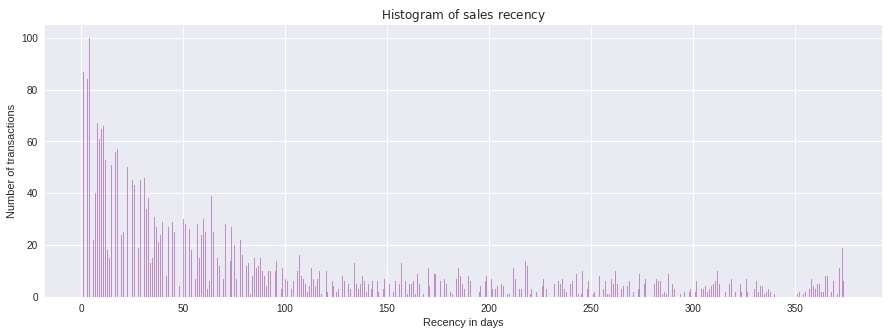

In [0]:
recen_graph = sp_customer_hist.select('recency').collect()

fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(recen_graph, bins = 1000, kde = False, color = 'purple')
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, '$\\mathrm{Histogram\\ of\\ sales\\ frequency}\\ $')

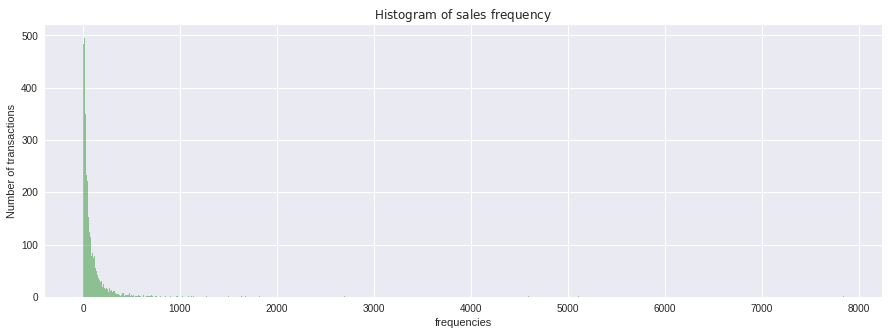

In [0]:
f_graph = sp_customer_hist.select('frequency').collect()

fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(f_graph, bins = 1000, kde = False, color = 'green')
plt.xlabel('frequencies')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ frequency}\ $')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 1000)

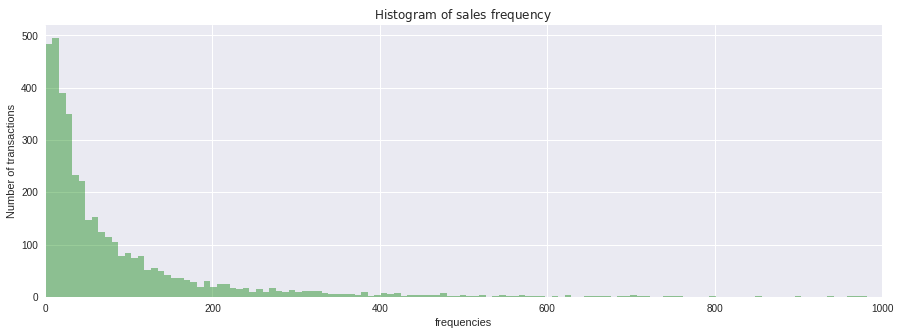

In [0]:
# limit the axis
fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(f_graph, bins = 1000, kde = False, color = 'green')
plt.xlabel('frequencies')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ frequency}\ $')
plt.xlim((0, 1000)) 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, '$\\mathrm{Histogram\\ of\\ sales\\ monetary}\\ $')

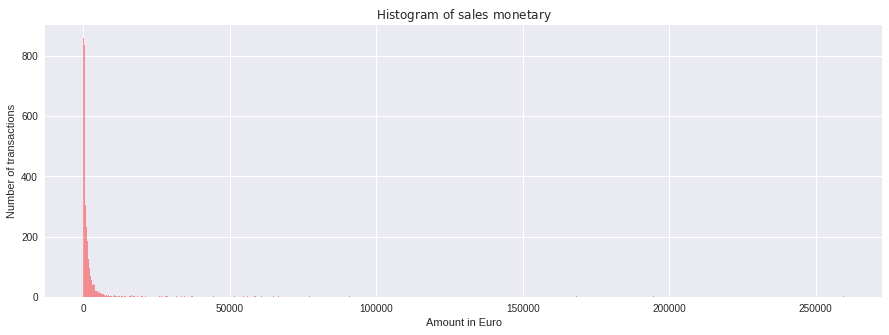

In [0]:
m_graph = sp_customer_hist.select('monetary').collect()

fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(m_graph, bins = 1000, kde = False, color = 'red')
plt.xlabel('Amount in Euro')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ monetary}\ $')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 5000)

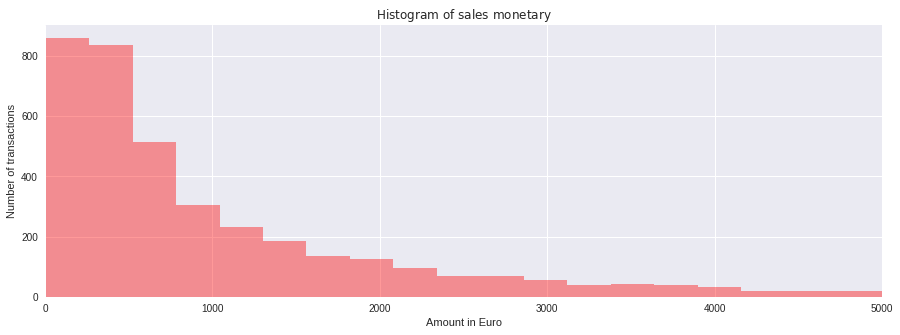

In [0]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(m_graph, bins = 1000, kde = False, color = 'red')
plt.xlabel('Amount in Euro')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ monetary}\ $')
plt.xlim((0, 5000)) 

In [0]:
sp_customer_hist = sp_customer_hist.withColumn('log_R', F.log('recency')).withColumn('log_F', F.log('frequency')).withColumn('log_M', F.log('monetary'))
sp_customer_hist.show(5)

+----------+-------+---------+------------------+------------------+------------------+-----------------+
|CustomerID|recency|frequency|          monetary|             log_R|             log_F|            log_M|
+----------+-------+---------+------------------+------------------+------------------+-----------------+
|   13094.0|   21.0|       24|1927.3200000000002| 3.044522437723423|3.1780538303479458|7.563885715862806|
|   13533.0|  183.0|       76|270.79000000000013| 5.209486152841421| 4.330733340286331|5.601343612734418|
|   13607.0|   40.0|       98| 678.0099999999996|3.6888794541139363| 4.584967478670572|6.519162037094163|
|   13918.0|   50.0|       30|           1212.84| 3.912023005428146|3.4011973816621555|7.100719995874571|
|   13956.0|    5.0|      152|1026.4199999999998|1.6094379124341003|5.0238805208462765|6.933832298692256|
+----------+-------+---------+------------------+------------------+------------------+-----------------+
only showing top 5 rows



In [0]:
log_r = sp_customer_hist.select('log_R').collect()
log_f = sp_customer_hist.select('log_F').collect()
log_m = sp_customer_hist.select('log_M').collect()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'histrogram of Log transformed customer monetary value')

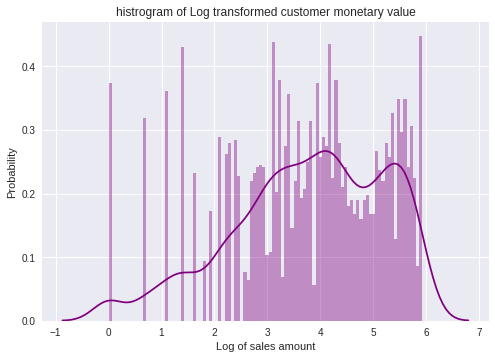

In [0]:
sns.distplot(log_r, bins=100, color = 'purple')
plt.xlabel('Log of sales amount')
plt.ylabel('Probability')
plt.title('histrogram of Log transformed customer recenccy value')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'histrogram of Log transformed customer monetary value')

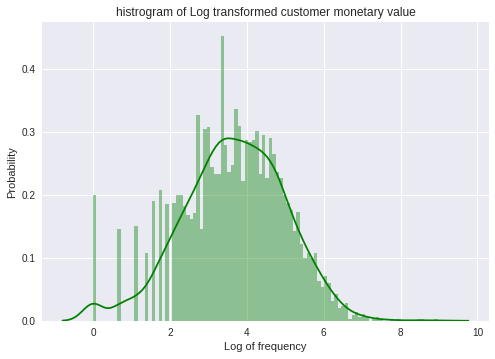

In [0]:
sns.distplot(log_f, bins=100, color = 'green')
plt.xlabel('Log of frequency')
plt.ylabel('Probability')
plt.title('histrogram of Log transformed frequency value')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'histrogram of Log transformed customer monetary value')

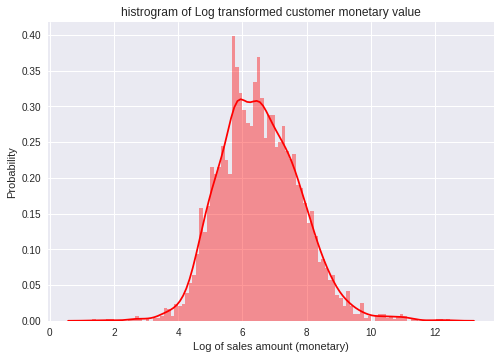

In [0]:
sns.distplot(log_m, bins=100, color = 'red')
plt.xlabel('Log of sales amount (monetary)')
plt.ylabel('Probability')
plt.title('histrogram of Log transformed customer monetary value')

Text(0.5, 0, 'Monetary')

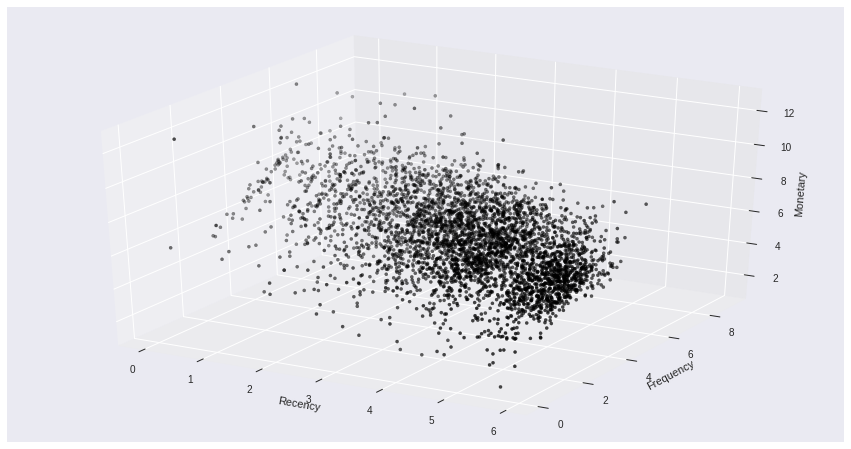

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111,projection='3d')

xs = log_r
ys = log_f
zs = log_m
ax.scatter(xs, ys, zs, s=10, c = 'k')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

/content/spark-2.4.1-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


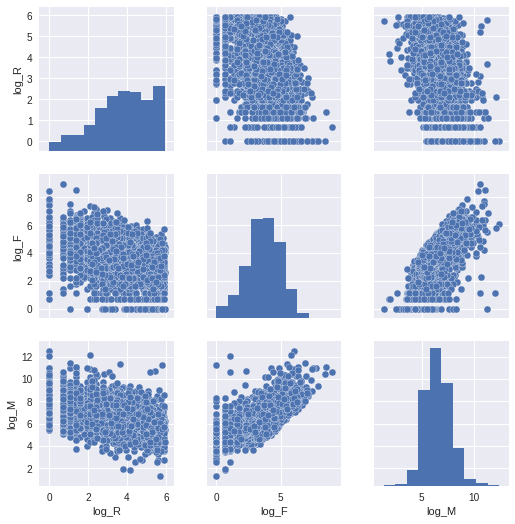

In [0]:
# Since seaborn did not provide format for Spark df. so we need to convert to Pandas 
log_pair_graph = sp_customer_hist.select(['log_R', 'log_F', 'log_M']).toPandas()
sns.pairplot(log_pair_graph)

##<font color = pink> K-means clustering
One disadvantage of KMeans compared to more advanced clustering algorithms is that the algorithm must be told how many clusters, k, it should try to find. 
To optimize k we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

In [0]:
# sp_log_graph_col = sp_customer_hist.select(['log_R', 'log_F', 'log_M']).collect()
sp_log_graph = sp_customer_hist.select(['CustomerID','log_R', 'log_F', 'log_M'])

In [0]:
FEATURES_COL = ['log_R', 'log_F', 'log_M']
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(sp_log_graph).select('CustomerID','features') # vecassembler will provide col 'features'
df_kmeans.show(5)

+----------+--------------------+
|CustomerID|            features|
+----------+--------------------+
|   13094.0|[3.04452243772342...|
|   13533.0|[5.20948615284142...|
|   13607.0|[3.68887945411393...|
|   13918.0|[3.91202300542814...|
|   13956.0|[1.60943791243410...|
+----------+--------------------+
only showing top 5 rows



In [0]:
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()
print("Cluster Centers: ")

# for center in centers:
#     print(center)

Cluster Centers: 
[2.35792971 4.13910907 6.81052558]
[4.39986985 4.24676989 7.09301356]
[3.88850328 3.11963465 5.97186366]
[5.39052191 3.08207946 5.77306085]
[0.93037467 5.49978499 8.52022365]
[3.05914156 5.29870872 8.06524126]
[2.65417837 2.20577929 5.3407152 ]
[5.17078906 1.39078015 4.89864302]


In [0]:
transformed = model.transform(df_kmeans).select('CustomerID', 'prediction')
transformed.show(5)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|   13094.0|         0|
|   13533.0|         3|
|   13607.0|         1|
|   13918.0|         1|
|   13956.0|         0|
+----------+----------+
only showing top 5 rows



In [0]:
sp_cluster = sp_log_graph.join(transformed, ['CustomerID'], how ='full')
# sp_cluster.show(5)

In [0]:
sp_cluster.show(5)

+----------+------------------+------------------+-----------------+----------+
|CustomerID|             log_R|             log_F|            log_M|prediction|
+----------+------------------+------------------+-----------------+----------+
|   13094.0| 3.044522437723423|3.1780538303479458|7.563885715862806|         0|
|   13533.0| 5.209486152841421| 4.330733340286331|5.601343612734418|         3|
|   13607.0|3.6888794541139363| 4.584967478670572|6.519162037094163|         1|
|   13918.0| 3.912023005428146|3.4011973816621555|7.100719995874571|         1|
|   13956.0|1.6094379124341003|5.0238805208462765|6.933832298692256|         0|
+----------+------------------+------------------+-----------------+----------+
only showing top 5 rows



##<font color = pink> Visualization with PySpark + Pandas

In [0]:
# as we defined log_* above 
X = log_r
Y = log_f
Z = log_m
pd_color_df = sp_cluster.select('prediction').select('*').toPandas() #dict in pySpark is complex so we will coonvert to Pandas

/content/spark-2.4.1-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [0]:
pd_color_series = pd_color_df.loc[:,'prediction']
LABEL_COLOR_MAP = {0 : 'orange',
                   1 : 'brown',
                   2 : 'c', 
                   3 : 'r',
                   4 : 'b',
                   5 : 'pink',
                   6 : 'purple',
                   7 : 'green',}

label_color = [LABEL_COLOR_MAP[l] for l in pd_color_series]

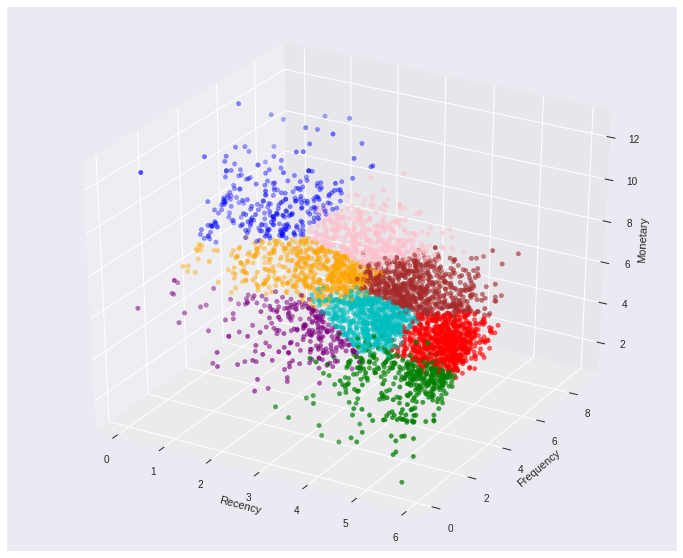

In [0]:
fig = plt.figure(figsize=(12,10)).gca(projection='3d')
fig.scatter(X, Y, Z, c = label_color)
fig.set_xlabel('Recency')
fig.set_ylabel('Frequency')
fig.set_zlabel('Monetary')
plt.show()

##<font color = pink> problem of visualization with PySpark
    
    The STRING column in Pyspark is very complex due to Scalar base. Although 

In [0]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

Text(0, 0.5, 'cost')

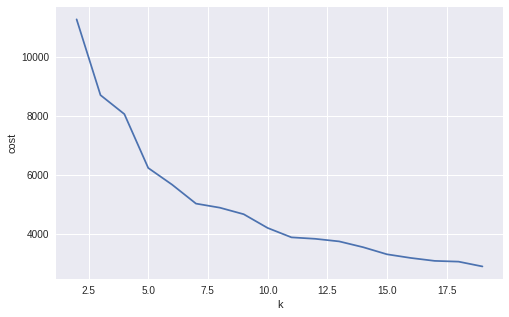

In [0]:
fig, ax = plt.subplots(1,1, figsize =(8,5))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [0]:
ls

'Cross Selling.ipynb'          'Online Retail.csv'
 cross_selling.py              'Online Retail.xlsx'
'Customer Segmentation.ipynb'   pruned_rule_uk_top10_item.csv
 customer_segmentation.py       pruned_rule_uk_top15_item.csv
 grocery_dataset_df.csv         README.md
 grocery_dataset.txt


In [0]:
log_pair_graph.to_csv('customer-seg_spark_log_pair_graph.csv')
from google.colab import files
files.download('customer-seg_spark_log_pair_graph.csv')

In [0]:
# sp_cluster = sp_cluster.withColumn('color', sp_cluster.prediction)
# sp_cluster = sp_cluster.withColumn("color", F.col("color").cast('string')) # In Spark, column type must be the same type with our replcing value.
# sp_cluster = sp_cluster.na.replace(['0','1','2'],['m','green','c'])
# sp_cluster.show(5)

In [0]:
# sp_color = sp_cluster.select('color').collect()

In [0]:
# fig = plt.figure(figsize=(12,10)).gca(projection='3d')
# fig.scatter(X, Y, Z, c = sp_color)
# fig.set_xlabel('Recency')
# fig.set_ylabel('Frequency')
# fig.set_zlabel('Monetary')
# plt.show()

In [0]:
# UPDATE `table_name` SET field_name = replace(field_name,'find this','replace with this');